In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn.functional as F

from src.sequence_datasets import * 

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
def set_plot_style():
    # Define the custom color palette
    custom_palette = [
        '#5F9EA0', # cadet blue
        '#FFD700', # gold
        '#FFA07A', # light salmon
        '#87CEEB', # light blue
        '#9370DB', # medium purple
        '#98FB98'  # pale green
    ]
    
    # Set the Seaborn palette
    sns.set_palette(custom_palette)
    
    # Set general plot aesthetics
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Update Matplotlib rcParams for consistent styling
    plt.rcParams.update({
        'figure.figsize': (12, 7),
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.title_fontsize': 13,
        'legend.fontsize': 11,
        'axes.titlepad': 20,
        'axes.labelpad': 10,
        'xtick.major.pad': 5,
        'ytick.major.pad': 5
    })

## 1- Import data from trained and untrained tasks + models. 

In [4]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET_Block3'

experiment = 'Experiment13_Task3_emb12_batch50'
models = np.sort(os.listdir(os.path.join(path_to_hnets, experiment)))[:5]

data_path = './Data/Sim_Data_Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path), 'rb') as fp:
    data_exp = pickle.load(fp)

In [5]:
model_0 = torch.load(os.path.join(path_to_hnets,experiment, 'Model_Task_0.pth'))
model_1 = torch.load(os.path.join(path_to_hnets,experiment, 'Model_Task_1.pth'))
model_2 = torch.load(os.path.join(path_to_hnets,experiment, 'Model_Task_2.pth'))
model_3 = torch.load(os.path.join(path_to_hnets,experiment, 'Model_Task_3.pth'))
model_4 = torch.load(os.path.join(path_to_hnets,experiment, 'Model_Task_4.pth'))

In [6]:
keys_training = list(data_exp.keys())[:5]
keys_testing = list(data_exp.keys())[5:]

## 2- Loss method

Check using 20 batches (20 times 50 trials from each task) if comparing the batch loss to the mean loss for the task is enough. 

In [7]:
# First using only model 4, we are going to compute the loss for the whole training dataset,
#  as well as the training loss for the different batches of the testing dataset

n_contexts = len(keys_training)
embedding = []
mean_loss_embeddding = []
tested_set = []
loss_set = []
num_batch = []

LSTM_ = True

for i in range(n_contexts):
    x_train, y_train = data_exp[keys_training[i]][0:2]
    model_4.to(device)
    W = model_4(cond_id = int(i))
    main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  
                              hidden_size = 300, num_layers= 1, out_dims=2,  
                              dropout= 0.2,  LSTM_ = LSTM_)
    # Move model to the correct device
    main_net.to(device)
    if LSTM_ == True:
        h0 = torch.randn(1, 50, 300, device= device) * 0.1
        c0 = torch.randn(1, 50, 300, device= device) * 0.1 # Initialize cell state
        hx = (h0, c0) 
    train_dataset = SequenceDataset(y_train, x_train, sequence_length=19)
    loader_train = data.DataLoader(train_dataset, batch_size=50, shuffle=True)
    loss_task = 0
    n_batches = 1
    for x,y in loader_train:
        x = x.to(device)
        y = y.to(device)
        y_pred = main_net(x, hx).to(device)
        loss_task +=  F.huber_loss(y_pred, y, delta=8).detach().numpy()
        n_batches += 1
    loss_real_task = loss_task / n_batches

    for t in range(n_contexts):
        x_train_2, y_train_2 = data_exp[keys_testing[t]][0:2]
        train_dataset_2 = SequenceDataset(y_train_2, x_train_2, sequence_length=19)
        loader_train_2 = data.DataLoader(train_dataset_2, batch_size=50, shuffle=True)
        n_count = 0
        for x_1, y_2 in loader_train_2:
            x = x_1.to(device)
            y = y_2.to(device)
            y_pred = main_net(x, hx).to(device)
            loss_batch =  F.huber_loss(y_pred, y, delta=8).detach().numpy()
            n_count += 1
            embedding.append('Emb'+ str(i) + '('+(keys_training[i])+')')
            mean_loss_embeddding.append(loss_real_task)
            tested_set.append(keys_testing[t])
            loss_set.append(loss_batch.item())
            num_batch.append(n_count)
            if n_count == 50:
                break


In [8]:
df = pd.DataFrame({'Used Embedding' : embedding, 
                   'Mean Task Loss' : mean_loss_embeddding, 
                   'Tested Set' : tested_set, 
                   'Loss Batch' : loss_set,
                   'Num Batch' : num_batch})

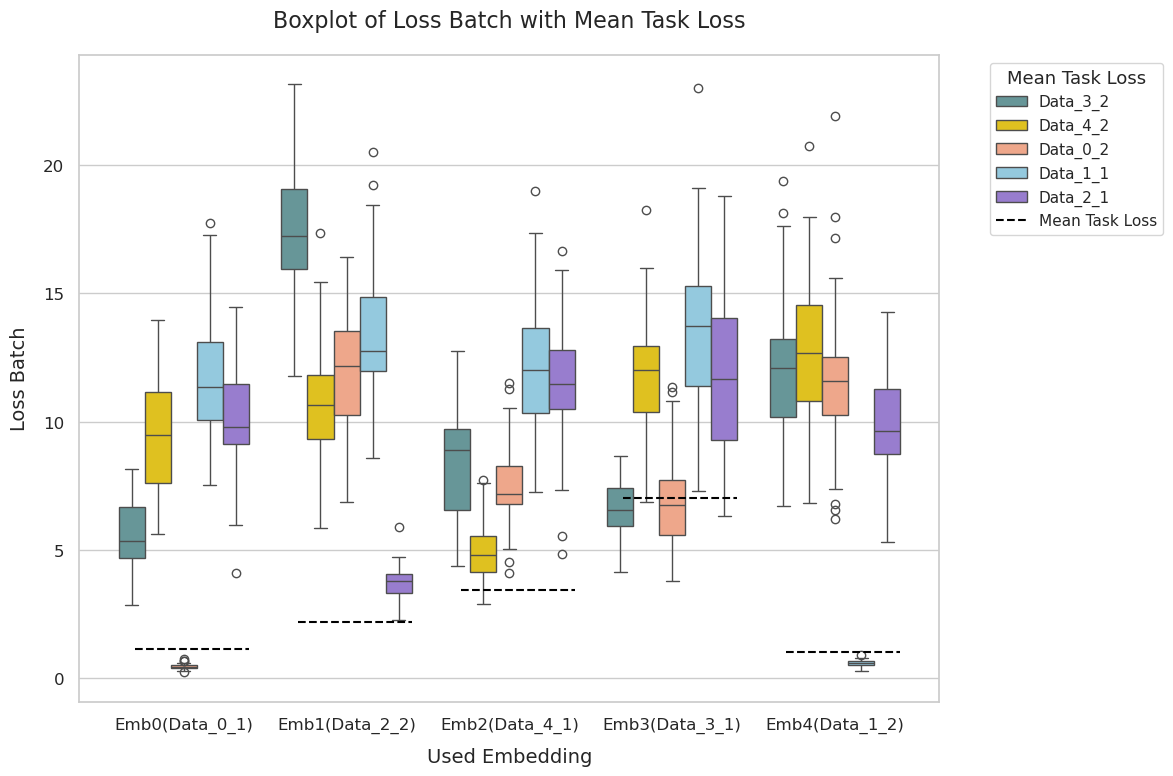

In [9]:
# Create the boxplot
plt.figure(figsize=(12, 8))
set_plot_style()
ax = sns.boxplot(x='Used Embedding', y='Loss Batch', hue='Tested Set', data=df)

# Get the unique values and their positions
unique_embeddings = df['Used Embedding'].unique()
n_hues = len(df['Tested Set'].unique())
positions = ax.get_xticks()  # x positions for each category

# Iterate over each embedding
for i, embedding in enumerate(unique_embeddings):
    # Calculate the mean task loss for each embedding
    mean_task_loss = df[df['Used Embedding'] == embedding]['Mean Task Loss'].values[0]

    # Define the xmin and xmax for each embedding
    xmin = positions[i] - 0.3
    xmax = positions[i] + 0.1 * (n_hues - 1)

    # Draw the horizontal dashed line
    plt.hlines(y=mean_task_loss, xmin=xmin, xmax=xmax, color='k', linestyle='--', label=f'Mean Task Loss' if i == 0 else "")

# Add labels and title
plt.xlabel('Used Embedding')
plt.ylabel('Loss Batch')
plt.title('Boxplot of Loss Batch with Mean Task Loss')
plt.legend(title='Mean Task Loss', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


## 3- Covariance method

Check using 20 batches (20 times 50 trials from each task) if comparing the batch covariance to the mean covariance for the task is enough. 

per each trained task compute the mean covariance
then for each tested task and batch compute the covariance and the covariance difference with all contexts. 

do boxplot of covariance difference and see if there is something we can do with that. 

In [14]:
def update_covariance_for_context(self, features, context):
    """Update the mean covariance matrix for a given context."""
    new_covariance = compute_covariance_matrix(features)

    # Update the rolling window of covariances
    self.rolling_covariances.append(new_covariance)
    if len(self.rolling_covariances) > 20: #was 15 before
        self.rolling_covariances.pop(0)

    # Compute mean of rolling covariances
    rolling_mean_covariance = self.compute_mean_covariance(self.rolling_covariances)

    # Update the mean covariance for the context
    if len(self.task_covariances) <= context:
        self.task_covariances.append(rolling_mean_covariance)
        self.task_cov_counts.append(1)
    else:
        self.task_covariances[context] = update_mean_covariance(
            self.task_covariances[context],
            rolling_mean_covariance,
            self.task_cov_counts[context]
        )
        self.task_cov_counts[context] += 1

In [15]:
def compute_mean_covariance(self, covariances):
    """Compute the mean of a list of covariance matrices."""
    return sum(covariances) / len(covariances)

## 5- Dimensionality reduction method

Use UMAP to try to see if we can create clusters of data. For every new batch, see if it falls in the same cluster and if there is a similarity metric which can capture the separation between clusters and the data nature. 

## 6- Other features for neural data

